In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras import models, layers
import keras_tuner

### Data load & preparation

In [2]:
plt.rcParams['figure.dpi'] = 130
plt.rcParams['figure.figsize'] = (8, 4)

In [3]:
tesla = pd.read_csv('tesla.csv')
tesla.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [4]:
tesla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [5]:
tesla.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


In [6]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


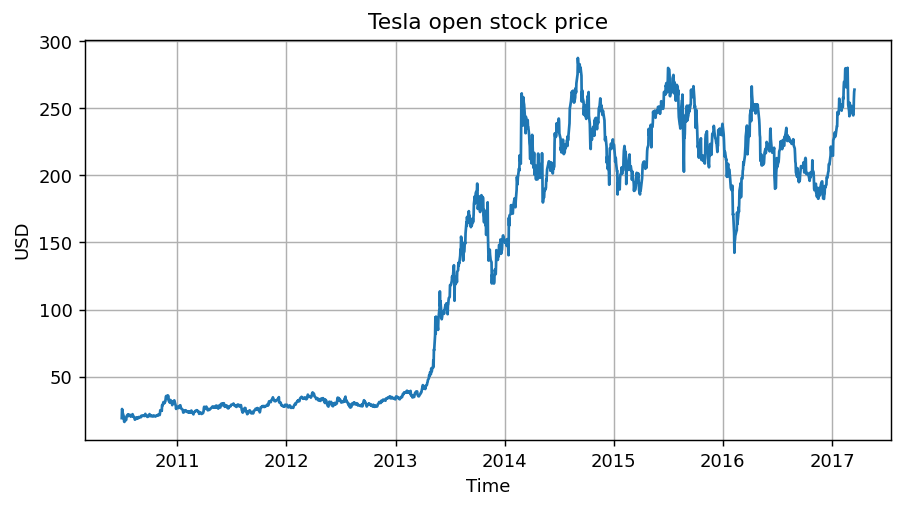

In [87]:
plt.plot(pd.to_datetime(tesla['Date']), tesla['Open'])
plt.grid()
plt.title('Tesla open stock price')
plt.xlabel('Time')
plt.ylabel('USD')
plt.show()

Train-test split

In [5]:
split_ratio = 0.8
train_len = round(split_ratio * len(tesla))
test_len = len(tesla) - train_len
train_data, train_dates = tesla[:train_len].Open.values.reshape(train_len, 1), pd.to_datetime(tesla[:train_len]['Date'])
test_data, test_dates = tesla[train_len:].Open.values.reshape(test_len, 1), pd.to_datetime(tesla[train_len:]['Date'])

Feature scaling

In [6]:
scaler = MinMaxScaler(feature_range = (0,1))
X_tr_scaled = scaler.fit_transform(train_data)
X_t_scaled = scaler.fit_transform(test_data)

In [7]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, train_len):
    X_train.append(X_tr_scaled[i-time_step:i, 0])
    y_train.append(X_tr_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

X_train shape: (1304, 50), y_train shape: (1304,)


In [8]:
X_test = []
y_test = []

time_step = 50

for i in range(time_step, test_len):
    X_test.append(X_t_scaled[i-time_step:i, 0])
    y_test.append(X_t_scaled[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_test shape: (288, 50), y_test shape: (288,)


In [9]:
X_train = X_train.reshape(1304, 50, 1)
y_train = y_train.reshape(1304, 1)
X_test = X_test.reshape(288, 50, 1)
y_test = y_test.reshape(288, 1)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (1304, 50, 1), y_train shape: (1304, 1)
X_test shape: (288, 50, 1), y_test shape: (288, 1)


### Building RNN

In [54]:
def build_model(hp):

    model = models.Sequential()

    model.add(layers.SimpleRNN(units = hp.Int('rnn1_units', min_value=50, max_value=150, step=50), 
                activation = 'tanh', 
                return_sequences = True, 
                input_shape = (50, 1)))

    model.add(layers.Dropout(0.2))

    model.add(layers.SimpleRNN(units = hp.Int('rnn2_units', min_value=50, max_value=150, step=50), 
                activation = 'tanh', 
                return_sequences = True))

    model.add(layers.Dropout(0.2))

    model.add(layers.SimpleRNN(units = hp.Int('rnn3_units', min_value=50, max_value=150, step=50), 
                activation = 'tanh', 
                return_sequences = True))

    model.add(layers.Dropout(0.2))

    model.add(layers.SimpleRNN(units = hp.Int('rnn4_units', min_value=50, max_value=150, step=50)))

    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

    return model


In [57]:
tuner = keras_tuner.RandomSearch(build_model, objective='val_accuracy', max_trials = 1)
x_tr = X_train[:-304]
y_tr = y_train[:-304]
x_val = X_train[-304:]
y_val = y_train[-304:]
tuner.search(x_tr, y_tr, epochs=3, validation_data=(x_val, y_val))

Trial 1 Complete [00h 00m 08s]
val_accuracy: 0.003289473708719015

Best val_accuracy So Far: 0.003289473708719015
Total elapsed time: 00h 00m 08s


In [58]:
rnn = tuner.get_best_models(num_models=1)[0]
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 150)           30150     
                                                                 
 dropout_1 (Dropout)         (None, 50, 150)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 150)           45150     
                                                                 
 dropout_2 (Dropout)         (None, 50, 150)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                1

In [59]:
rnn_history = rnn.fit(X_train, y_train, epochs = 50, batch_size = 64)

Epoch 1/50
21/21 [==============================] - 4s 44ms/step - loss: 0.2732 - accuracy: 7.6687e-04
Epoch 2/50
21/21 [==============================] - 1s 59ms/step - loss: 0.2410 - accuracy: 7.6687e-04
Epoch 3/50
21/21 [==============================] - 2s 99ms/step - loss: 0.2100 - accuracy: 7.6687e-04
Epoch 4/50
21/21 [==============================] - 2s 96ms/step - loss: 0.1794 - accuracy: 0.0000e+00
Epoch 5/50
21/21 [==============================] - 2s 98ms/step - loss: 0.1597 - accuracy: 0.0000e+00
Epoch 6/50
21/21 [==============================] - 2s 97ms/step - loss: 0.1366 - accuracy: 0.0000e+00
Epoch 7/50
21/21 [==============================] - 2s 96ms/step - loss: 0.1189 - accuracy: 7.6687e-04
Epoch 8/50
21/21 [==============================] - 2s 100ms/step - loss: 0.0833 - accuracy: 7.6687e-04
Epoch 9/50
21/21 [==============================] - 2s 97ms/step - loss: 0.0772 - accuracy: 7.6687e-04
Epoch 10/50
21/21 [==============================] - 2s 99ms/step - loss

In [71]:
y_pred_rnn = rnn.predict(X_test)
y_pred_rnn_noscaling = scaler.inverse_transform(y_pred_rnn)
y_test_noscaling = scaler.inverse_transform(y_test)

9/9 [==============================] - 0s 18ms/step


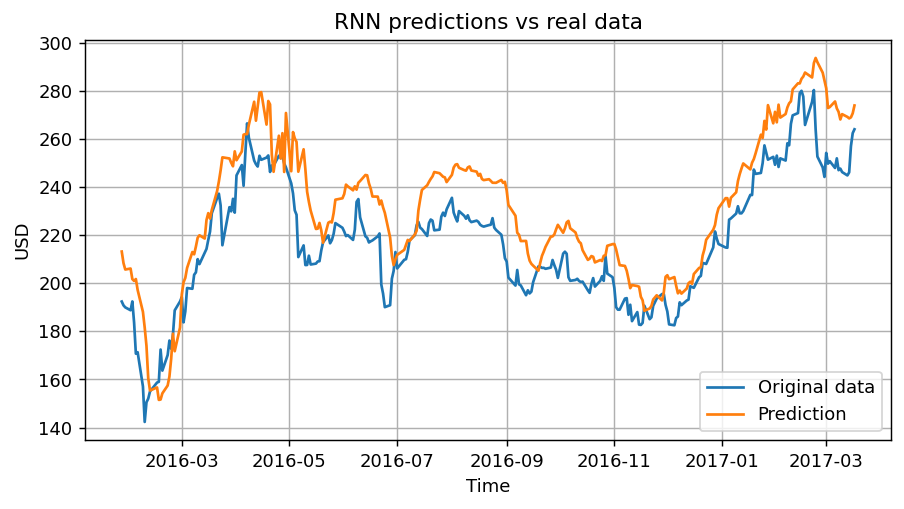

In [93]:
plt.plot(test_dates[50:], y_test_noscaling, label='Original data')
plt.plot(test_dates[50:], y_pred_rnn_noscaling, label='Prediction')
plt.legend()
plt.grid()
plt.title('RNN predictions vs real data')
plt.xlabel('Time')
plt.ylabel('USD')
plt.show()

In [102]:
RMSE = np.sqrt(np.square(np.subtract(y_test_noscaling, y_pred_rnn_noscaling)).mean())
RMSE

17.36466728464864

### Building LSTM

In [88]:
def build_model2(hp):

    model = models.Sequential()
    model.add(layers.LSTM(units=hp.Int('lstm1_units', min_value=64, max_value=128, step=32), return_sequences=True, input_shape=(50,1))) 
    model.add(layers.LSTM(units=hp.Int('lstm1_units', min_value=64, max_value=128, step=32), return_sequences=False))
    model.add(layers.Dense(units=hp.Int('lstm1_units', min_value=32, max_value=128, step=32)))
    model.add(layers.Dense(1))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])

    return model

In [90]:
tuner2 = keras_tuner.RandomSearch(build_model2, objective='val_accuracy', max_trials = 1)
x_tr = X_train[:-304]
y_tr = y_train[:-304]
x_val = X_train[-304:]
y_val = y_train[-304:]
tuner2.search(x_tr, y_tr, epochs=3, validation_data=(x_val, y_val))

Trial 1 Complete [00h 00m 09s]
val_accuracy: 0.003289473708719015

Best val_accuracy So Far: 0.003289473708719015
Total elapsed time: 00h 00m 09s


In [91]:
lstm = tuner2.get_best_models(num_models=1)[0]
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 lstm_1 (LSTM)               (None, 96)                74112     
                                                                 
 dense (Dense)               (None, 96)                9312      
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 121153 (473.25 KB)
Trainable params: 121153 (473.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
lstm_history = lstm.fit(X_train, y_train, epochs = 50, batch_size = 64)

Epoch 1/50
21/21 [==============================] - 4s 51ms/step - loss: 0.0015 - accuracy: 7.6687e-04
Epoch 2/50
21/21 [==============================] - 1s 45ms/step - loss: 0.0010 - accuracy: 7.6687e-04
Epoch 3/50
21/21 [==============================] - 1s 44ms/step - loss: 0.0011 - accuracy: 7.6687e-04
Epoch 4/50
21/21 [==============================] - 1s 44ms/step - loss: 9.8303e-04 - accuracy: 7.6687e-04
Epoch 5/50
21/21 [==============================] - 1s 45ms/step - loss: 0.0010 - accuracy: 7.6687e-04
Epoch 6/50
21/21 [==============================] - 1s 46ms/step - loss: 9.2287e-04 - accuracy: 7.6687e-04
Epoch 7/50
21/21 [==============================] - 1s 44ms/step - loss: 9.4845e-04 - accuracy: 7.6687e-04
Epoch 8/50
21/21 [==============================] - 1s 44ms/step - loss: 8.6088e-04 - accuracy: 7.6687e-04
Epoch 9/50
21/21 [==============================] - 1s 47ms/step - loss: 8.5128e-04 - accuracy: 7.6687e-04
Epoch 10/50
21/21 [==============================] - 

In [94]:
y_pred_lstm = lstm.predict(X_test)
y_pred_lstm_noscaling = scaler.inverse_transform(y_pred_lstm)
y_test_noscaling = scaler.inverse_transform(y_test)

9/9 [==============================] - 1s 19ms/step


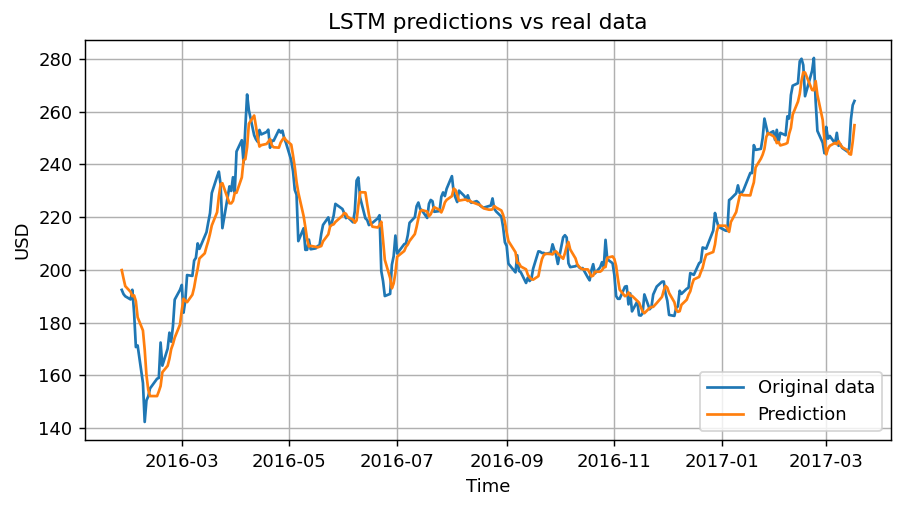

In [95]:
plt.plot(test_dates[50:], y_test_noscaling, label='Original data')
plt.plot(test_dates[50:], y_pred_lstm_noscaling, label='Prediction')
plt.legend()
plt.grid()
plt.title('LSTM predictions vs real data')
plt.xlabel('Time')
plt.ylabel('USD')
plt.show()

In [103]:
RMSE2 = np.sqrt(np.square(np.subtract(y_test_noscaling, y_pred_lstm_noscaling)).mean())
RMSE2

6.870514345795979

### Building GRU

In [4]:
def build_model3(hp):

    model = models.Sequential()
    model.add(layers.GRU(units=hp.Int('lstm1_units', min_value=64, max_value=128, step=32), return_sequences=True, input_shape=(50,1))) 
    model.add(layers.GRU(units=hp.Int('lstm1_units', min_value=64, max_value=128, step=32), return_sequences=False))
    model.add(layers.Dense(units=hp.Int('lstm1_units', min_value=32, max_value=128, step=32)))
    model.add(layers.Dense(1))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])

    return model

In [10]:
tuner3 = keras_tuner.RandomSearch(build_model3, objective='val_accuracy', max_trials = 1)
x_tr = X_train[:-304]
y_tr = y_train[:-304]
x_val = X_train[-304:]
y_val = y_train[-304:]
tuner3.search(x_tr, y_tr, epochs=3, validation_data=(x_val, y_val))

Trial 1 Complete [00h 00m 11s]
val_accuracy: 0.003289473708719015

Best val_accuracy So Far: 0.003289473708719015
Total elapsed time: 00h 00m 11s


In [11]:
gru = tuner3.get_best_models(num_models=1)[0]
gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 96)            28512     
                                                                 
 gru_1 (GRU)                 (None, 96)                55872     
                                                                 
 dense (Dense)               (None, 96)                9312      
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 93793 (366.38 KB)
Trainable params: 93793 (366.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
gru_history = gru.fit(X_train, y_train, epochs = 50, batch_size = 64)

Epoch 1/50
21/21 [==============================] - 6s 60ms/step - loss: 5.7867e-04 - accuracy: 7.6687e-04
Epoch 2/50
21/21 [==============================] - 1s 53ms/step - loss: 5.4418e-04 - accuracy: 7.6687e-04
Epoch 3/50
21/21 [==============================] - 1s 53ms/step - loss: 5.2059e-04 - accuracy: 7.6687e-04
Epoch 4/50
21/21 [==============================] - 1s 52ms/step - loss: 4.8203e-04 - accuracy: 7.6687e-04
Epoch 5/50
21/21 [==============================] - 1s 51ms/step - loss: 4.3702e-04 - accuracy: 7.6687e-04
Epoch 6/50
21/21 [==============================] - 1s 56ms/step - loss: 4.3197e-04 - accuracy: 7.6687e-04
Epoch 7/50
21/21 [==============================] - 1s 56ms/step - loss: 5.0758e-04 - accuracy: 7.6687e-04
Epoch 8/50
21/21 [==============================] - 1s 54ms/step - loss: 4.0426e-04 - accuracy: 7.6687e-04
Epoch 9/50
21/21 [==============================] - 1s 57ms/step - loss: 4.0179e-04 - accuracy: 7.6687e-04
Epoch 10/50
21/21 [==================

In [13]:
y_pred_gru = gru.predict(X_test)
y_pred_gru_noscaling = scaler.inverse_transform(y_pred_gru)
y_test_noscaling = scaler.inverse_transform(y_test)

9/9 [==============================] - 1s 16ms/step


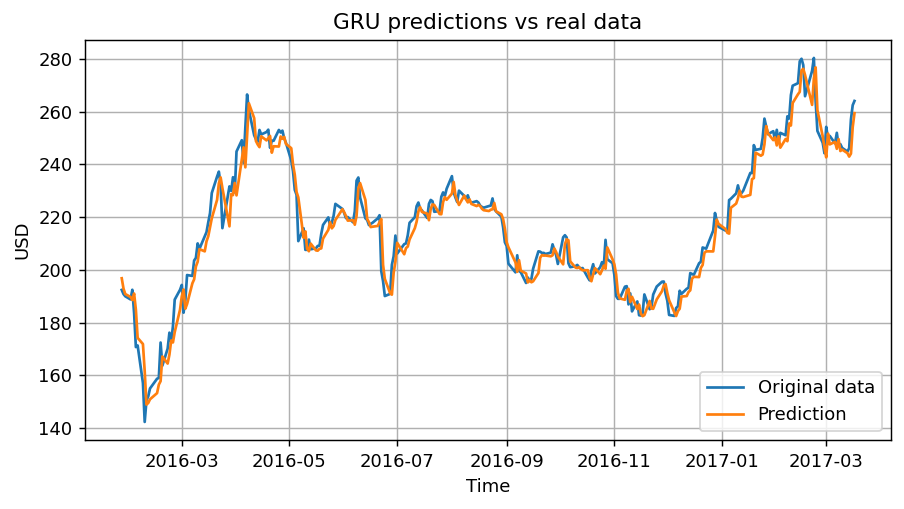

In [17]:
plt.plot(test_dates[50:], y_test_noscaling, label='Original data')
plt.plot(test_dates[50:], y_pred_gru_noscaling, label='Prediction')
plt.legend()
plt.grid()
plt.title('GRU predictions vs real data')
plt.xlabel('Time')
plt.ylabel('USD')
plt.show()

In [16]:
RMSE3 = np.sqrt(np.square(np.subtract(y_test_noscaling, y_pred_gru_noscaling)).mean())
RMSE3

5.7004806946261235